# Example of openloop gate optimization

### Import and definitions

In [14]:
import numpy as np
import tensorflow as tf
from scipy.linalg import expm

In [15]:
import c3po.control as control
import c3po.component as component
import c3po.generator as generator
import c3po.envelopes as envelopes
import c3po.hamiltonians as hamiltonians

In [16]:
from c3po.model import Model as Mdl
from c3po.simulator import Simulator as Sim
from c3po.optimizer import Optimizer as Opt
from c3po.experiment import Experiment as Exp

In [17]:
from c3po.utils import log_setup
from c3po.tf_utils import tf_abs, tf_ave
from c3po.tf_utils import tf_limit_gpu_memory as tf_limit_gpu_memory
from c3po.qt_utils import basis, xy_basis, perfect_gate

### Specify parameters of the system

In [18]:
# System
qubit_freq = 5e9 * 2 * np.pi
qubit_anhar = -250e6 * 2 * np.pi
qubit_lvls = 4
drive_ham = hamiltonians.x_drive
v_hz_conversion = 1
t_final = 25e-9

In [19]:
# Resolutions
sim_res = 250e9
bawg_res = 1e9

In [20]:
# Directory to log into
logdir = log_setup("/tmp/c3logs/")

### Create model object that contains information on the Hamiltonians

In [21]:
q1 = component.Qubit(
    name="Q1",
    desc="Qubit 1",
    comment="The one and only qubit in this chip",
    freq=qubit_freq,
    anhar=qubit_anhar,
    hilbert_dim=qubit_lvls
)
drive = component.Drive(
    name="D1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian=drive_ham
)
chip_elements = [q1, drive]
model = Mdl(chip_elements)

### Create generator object that contains information of the dontrol lines

In [22]:
# Takes parameters and get AWG bin values
awg = generator.AWG(resolution=awg_res, logdir=logdir)
# Reshapes the signal from the AWG samples to the simulation resolution
dig_to_an = generator.Digital_to_Analog(resolution=sim_res)
# Adds a risetime to the AWG signal
resp = generator.Response(rise_time=0.1e-9, resolution=sim_res)
# Creates the LO signal
lo = generator.LO(resolution=sim_res)
# Mixes LO and AWG signals
mixer = generator.Mixer()
# Transforms signal from a given voltage on the device to Hz (that go in front of the Hamiltonian)
v_to_hz = generator.Volts_to_Hertz(V_to_Hz=v_hz_conversion)

In [23]:
# Pass all of these devices to the generator object that uses them to make signal from parameters
devices = [lo, awg, mixer, v_to_hz, dig_to_an, resp]
gen = generator.Generator(devices)

In [24]:
# If desired implement automatic DRAG correction of the pulse.
# gen.devices['awg'].options = 'drag'

### Create gates/operations to implement

In [25]:
# Define parameters and bounds of given envelope function
gauss_params = {
    'amp': 0.5 * np.pi / v_hz_conversion,
    't_final': t_final,
    'xy_angle': 0.0,
    'freq_offset': 0 * 2 * np.pi,
    'delta': 1 / qubit_anhar
}
gauss_bounds = {
    'amp': [0.01 * np.pi / v_hz_conversion, 1.5 * np.pi / v_hz_conversion],
    't_final': [1e-9, 30e-9],
    'xy_angle': [-1 * np.pi/2, 1 * np.pi/2],
    'freq_offset': [-100 * 1e6 * 2 * np.pi, 100 * 1e6 * 2 * np.pi],
    'delta': [10/qubit_anhar, 0.1/qubit_anhar]
}
# Create envelope object, the function is taken from our library in envelopes.py
gauss_env = control.Envelope(
    name="gauss",
    desc="Gaussian envelope",
    params=gauss_params,
    bounds=gauss_bounds,
    shape=envelopes.gaussian
)

In [26]:
# Define parameters and bounds of the carrier (this will be used by the LO)
carrier_parameters = {
    'freq': qubit_freq
}
carrier_bounds = {
    'freq': [4e9 * 2 * np.pi, 7e9 * 2 * np.pi]
}
# Create carrier object
carr = control.Carrier(
    name="carrier",
    desc="Frequency of the local oscillator",
    params=carrier_parameters,
    bounds=carrier_bounds
)

In [27]:
# Create Gate/operation and pass envelope and carrier
X90p = control.Instruction(
    name="X90p",
    t_start=0.0,
    t_end=t_final,
    channels=["d1"]
)
X90p.add_component(gauss_env, "d1")
X90p.add_component(carr, "d1")

In [28]:
# Create gateset object and pass the gate created
gates = control.GateSet()
gates.add_instruction(X90p)

### Create experiment class and simulator (this is where the computation of the unitary is done)

In [29]:
# Simulation class and fidelity function
exp = Exp(model, gen)
sim = Sim(exp, gates)

In [30]:
# Introduce a Z rotation of the unitary after the gate to rotate back into the qubit frame
a_q = model.ann_opers[0]
sim.VZ = expm(1.0j * np.matmul(a_q.T.conj(), a_q) * qubit_freq * t_final)

### Create optimizer object

In [31]:
# Optimizer object
opt = Opt(data_path=logdir)

In [32]:
# Define the map of which parameters will be optimized. The rest will be fixed
opt_map = [
    [('X90p', 'd1', 'gauss', 'amp')],
    [('X90p', 'd1', 'gauss', 'freq_offset')],
    [('X90p', 'd1', 'gauss', 'xy_angle')],
    # [('X90p', 'd1', 'gauss', 'delta')] # This is a DRAG parameter.
]

In [33]:
# Define states & unitaries
ket_0 = tf.constant(basis(qubit_lvls, 0), dtype=tf.complex128)
bra_yp = tf.constant(xy_basis(qubit_lvls, 'yp').T, dtype=tf.complex128)
X90p = tf.constant(perfect_gate(qubit_lvls, 'X90p'), dtype=tf.complex128)

In [34]:
# Choose which type of optimization to do, state transfer or unitary.
def state_transfer_infid(U_dict: dict):
    U = U_dict['X90p']
    ket_actual = tf.matmul(U, ket_0)
    overlap = tf_abs(tf.matmul(bra_yp, ket_actual))
    infid = 1 - overlap
    return infid

def unitary_infid(U_dict: dict):
    U = U_dict['X90p']
    unit_fid = tf_abs(
                tf.linalg.trace(
                    tf.matmul(U, tf.linalg.adjoint(X90p))
                    ) / 2
                )**2
    infid = 1 - unit_fid
    return infid

In [35]:
opt.optimize_controls(
    sim=sim,
    opt_map=opt_map,
    opt='lbfgs',
    opt_name='openloop',
    fid_func=unitary_infid
)

Saving as:
/tmp/c3logs/2019_11_14_T_13_58_14/openloop.log


# Plotting

You can run the code below in a different kernel to get a live plot. Or look a the log e.g.

$ less /tmp/c3logs/recent/openloop.log
(press F to get a continuous feed)

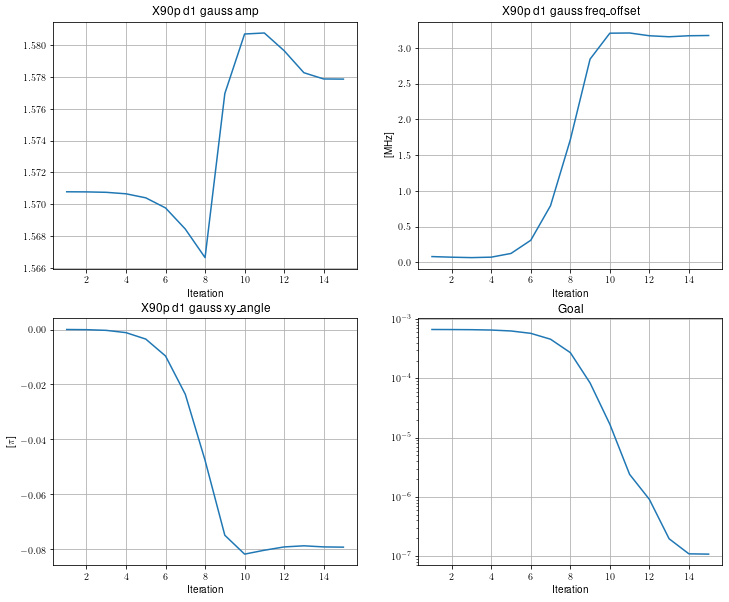

In [36]:
from c3po.display import plot_OC_logs
plot_OC_logs("/tmp/c3logs/recent/openloop.log")